Centroids:
 [[0.33125483 0.7974767  0.50576309 ... 0.38120864 0.19557756 0.5290271 ]
 [0.22877403 0.95204479 0.59174069 ... 0.28649585 0.13480743 0.34727635]
 [0.22866729 0.95460446 0.59105977 ... 0.28753116 0.13500179 0.3480474 ]
 ...
 [0.22851388 0.96001512 0.58951665 ... 0.28997623 0.13551203 0.34997536]
 [0.22849265 0.96187662 0.58894076 ... 0.29092716 0.13572998 0.3507666 ]
 [0.22867296 0.95445656 0.59109983 ... 0.28746955 0.13498986 0.34800077]]


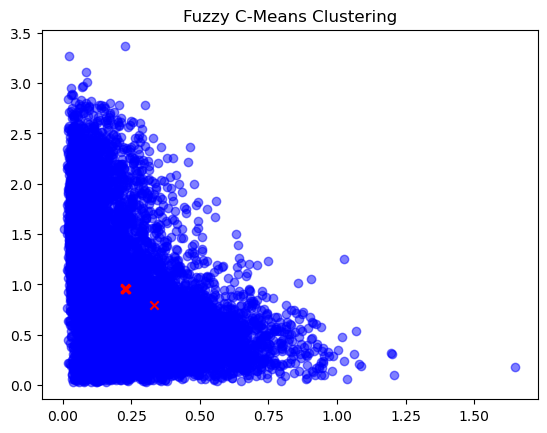

Initial GMM parameters:
Means:
 [[0.4170225  0.67911069 0.456903   ... 0.38765146 0.22551951 0.60391435]
 [0.24552308 0.65724637 0.59010308 ... 0.27203841 0.14025839 0.37193019]
 [0.13233574 2.01373453 0.39665645 ... 0.30966289 0.07958267 0.18083808]
 ...
 [0.31905484 0.22395871 0.85036644 ... 0.26022235 0.23912674 0.32720952]
 [0.20881794 1.02325662 0.57766339 ... 0.11692161 0.03141807 0.2593562 ]
 [0.10879951 1.10916828 0.69549409 ... 0.27077151 0.10818414 0.3581402 ]]
Covariances:
 [[[ 3.12367643e-02 -1.86789637e-02  4.87839692e-03 ... -6.61951049e-04
    5.95453480e-03 -3.80398279e-03]
  [-1.86789637e-02  5.26519524e-02  1.27352373e-03 ...  2.72678527e-03
   -7.68668906e-03  1.87341906e-03]
  [ 4.87839692e-03  1.27352373e-03  3.03620045e-02 ...  7.78880848e-03
    6.95987195e-03 -8.38507863e-03]
  ...
  [-6.61951049e-04  2.72678527e-03  7.78880848e-03 ...  1.61126065e-02
    6.86430645e-03 -5.23490828e-03]
  [ 5.95453480e-03 -7.68668906e-03  6.95987195e-03 ...  6.86430645e-03
    1

In [2]:
import torch
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist

# Load the features from a .pt file stored locally
features_path = 'imbalanced_train_features.pt'
features = torch.load(features_path).numpy()

# Perform FCM
n_clusters = 10
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(features.T, n_clusters, 2, error=0.005, maxiter=1000, init=None)

# Print centroids
print("Centroids:\n", cntr)

# Plot the data and centroids
plt.scatter(features[:, 0], features[:, 1], c='blue', marker='o', alpha=0.5)
plt.scatter(cntr[:, 0], cntr[:, 1], c='red', marker='x')
plt.title('Fuzzy C-Means Clustering')
plt.show()

# Initialize GMM Parameters
def initialize_gmm_parameters(data, cntr, n_clusters):
    gmm = GaussianMixture(n_components=n_clusters, means_init=cntr)
    gmm.fit(data)
    return gmm

gmm = initialize_gmm_parameters(features, cntr, n_clusters)
mu = gmm.means_
sigma = gmm.covariances_

print("Initial GMM parameters:")
print("Means:\n", mu)
print("Covariances:\n", sigma)

# Select all the 9 minority components (those with lower mixing coefficients)
mixing_coefficients = gmm.weights_
minority_indices = np.argsort(mixing_coefficients)[:9]  
print("Minority components indices:", minority_indices)

# Apply GMM for each minority cluster
def apply_gmm_to_minority(data, majority_data, minority_indices):
    gmm_params = {}
    for index in minority_indices:
        minority_data = data[np.argmax(u, axis=0) == index]
        if len(minority_data) < 2:  # Check if there are at least two samples
            continue
        m_comp = len(majority_data) / len(minority_data)
        n_components = max(1, int(np.round(m_comp)))  # Ensure n_components is at least 1
        gmm = GaussianMixture(n_components=min(n_components, len(minority_data)), init_params='kmeans')
        gmm.fit(minority_data)
        gmm_params[index] = (gmm.means_, gmm.covariances_, m_comp)
    return gmm_params

majority_class_indices = np.argmax(u, axis=0) == 0
majority_data = features[majority_class_indices]
gmm_params = apply_gmm_to_minority(features, majority_data, minority_indices)

def find_k_nearest_neighbours(data, means, k):
    distances = cdist(data, means)
    k_nearest_indices = np.argsort(distances, axis=1)[:, :k]
    k_nearest_means = means[k_nearest_indices]
    return k_nearest_means

k = 3

# Vectorized version of generate_new_elements function
def generate_new_elements(minority_data, k_nearest_means, sigma, k, n_c):
    minority_data = minority_data[:, np.newaxis, :]
    
    mux = (np.sum(k_nearest_means, axis=1) + minority_data) / (k + 1)
    
    sigmax = (np.sum(sigma, axis=0) + np.cov(minority_data.squeeze().T)) / (k + 1)
    
    # Generate new elements separately for each mean vector in mux
    new_elements = []
    for mean in mux.reshape(-1, mux.shape[-1]):
        new_elements.append(np.random.multivariate_normal(mean, sigmax, n_c))
    
    return np.vstack(new_elements)

new_elements = []

for index in minority_indices:
    minority_data = features[np.argmax(u, axis=0) == index]
    if len(minority_data) < 2:  
        continue
    
    # Convert minority_data to a numpy array
    minority_data = minority_data.astype(np.float32)
    
    # Retrieve the GMM parameters (means and covariances)
    means, covariances, m_comp = gmm_params[index]
    means = means.astype(np.float32)
    covariances = covariances.astype(np.float32)

    if m_comp >= k:
        # Find the k-nearest means
        k_nearest_means = find_k_nearest_neighbours(minority_data, means, k)
        n_c = max(1, (len(majority_data) - len(minority_data)) // len(minority_data))
        
        # Generate new elements using the vectorized function
        new_elements_class = generate_new_elements(minority_data, k_nearest_means, covariances, k, n_c)
        new_elements.append(new_elements_class)
    else:
        n_comp = max(1, len(majority_data) // len(minority_data))  
        gmm = GaussianMixture(n_components=min(n_comp, len(minority_data)), init_params='kmeans')
        gmm.fit(minority_data) 
        
        # Move the newly fitted GMM parameters to numpy arrays
        means = gmm.means_.astype(np.float32)
        covariances = gmm.covariances_.astype(np.float32)
        
        # Find the k-nearest means
        k_nearest_means = find_k_nearest_neighbours(minority_data, means, k)
        n_c = max(1, len(minority_data) * (len(majority_data) // n_comp) // len(minority_data))
        
        # Generate new elements
        new_elements_class = generate_new_elements(minority_data, k_nearest_means, covariances, k, n_c)
        new_elements.append(new_elements_class)

new_elements = np.vstack(new_elements)

plt.scatter(features[:, 0], features[:, 1], c='blue', marker='o', alpha=0.5, label='Original Data')
plt.scatter(new_elements[:, 0], new_elements[:, 1], c='green', marker='s', alpha=0.5, label='Generated Data')
plt.title('Original and Generated Data Points')
plt.legend()
plt.show()
